# Deteksi Penyakit pada Kulit Wajah Manusia 

## Load Data

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hilmiher","key":"c24dffbf6e4185ebb5ef4de87d98c8d4"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d hilmiher/face-disease

 98% 276M/282M [00:02<00:00, 82.1MB/s]
100% 282M/282M [00:03<00:00, 98.3MB/s]


In [ ]:
!mkdir dataset

In [ ]:
!unzip face-disease.zip -d dataset

Archive:  face-disease.zip
  inflating: dataset/Dataset/train/blackhead/00000025.jpg  
  inflating: dataset/Dataset/train/blackhead/00000026.jpg  
  inflating: dataset/Dataset/train/blackhead/00000039.jpg  
  inflating: dataset/Dataset/train/blackhead/00000044.jpg  
  inflating: dataset/Dataset/train/blackhead/00000045.jpg  
  inflating: dataset/Dataset/train/blackhead/00000046.jpg  
  inflating: dataset/Dataset/train/blackhead/00000047.jpg  
  inflating: dataset/Dataset/train/blackhead/00000048.jpg  
  inflating: dataset/Dataset/train/blackhead/00000051.jpg  
  inflating: dataset/Dataset/train/blackhead/00000054.jpg  
  inflating: dataset/Dataset/train/blackhead/00000055.jpg  
  inflating: dataset/Dataset/train/blackhead/00000058.jpg  
  inflating: dataset/Dataset/train/blackhead/00000061.jpg  
  inflating: dataset/Dataset/train/blackhead/00000062.jpg  
  inflating: dataset/Dataset/train/blackhead/00000066.jpg  
  inflating: dataset/Dataset/train/blackhead/00000069.jpg  
  inflating: 

## Image Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

train_dir = os.path.join('/content/dataset/Dataset/train/')
val_dir = os.path.join('/content/dataset/Dataset/validation')

train_datagen = ImageDataGenerator(rescale=1./225,
                                   rotation_range = 20,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   fill_mode = 'nearest')
val_datagen = ImageDataGenerator(rescale=1./225)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',   
)
validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical', 
)

Found 1551 images belonging to 9 classes.
Found 520 images belonging to 9 classes.


## Modelling

### Transfer Learning MobileNetV2

In [ ]:
import tensorflow as tf

image_size = 160
IMG_SHAPE = (image_size, image_size, 3)

#Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


### Sequential Model

In [ ]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    base_model,
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),  
    tf.keras.layers.Dense(9, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 16)          184336    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 512)               8704      
                                                                 
 dense_4 (Dense)             (None, 64)               

### Compile and Training

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 70,
                    verbose=1)

Epoch 1/70
28/49 [================>.............] - ETA: 12s - loss: 2.1075 - accuracy: 0.2059

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


49/49 [==============================] - 43s 810ms/step - loss: 2.0259 - accuracy: 0.2444 - val_loss: 1.9556 - val_accuracy: 0.2827
Epoch 2/70
49/49 [==============================] - 38s 785ms/step - loss: 1.6704 - accuracy: 0.4049 - val_loss: 1.8608 - val_accuracy: 0.3212
Epoch 3/70
49/49 [==============================] - 38s 777ms/step - loss: 1.4718 - accuracy: 0.4745 - val_loss: 1.5767 - val_accuracy: 0.4154
Epoch 4/70
49/49 [==============================] - 39s 788ms/step - loss: 1.3283 - accuracy: 0.5358 - val_loss: 1.5338 - val_accuracy: 0.4712
Epoch 5/70
49/49 [==============================] - 37s 764ms/step - loss: 1.2334 - accuracy: 0.5667 - val_loss: 1.5331 - val_accuracy: 0.4558
Epoch 6/70
49/49 [==============================] - 38s 769ms/step - loss: 1.1647 - accuracy: 0.6003 - val_loss: 1.4801 - val_accuracy: 0.5019
Epoch 7/70
49/49 [==============================] - 37s 770ms/step - loss: 1.0860 - accuracy: 0.6157 - val_loss: 1.4870 - val_accuracy: 0.4769
Epoch 8/70

### Save Model

In [ ]:
model.save('saved_model/my_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### Training Result Chart

Text(0.5, 1.0, 'Training and validation loss')

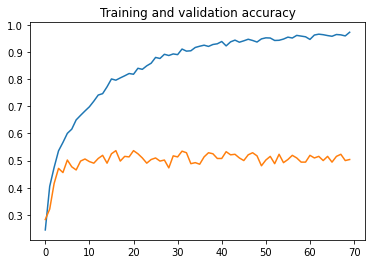

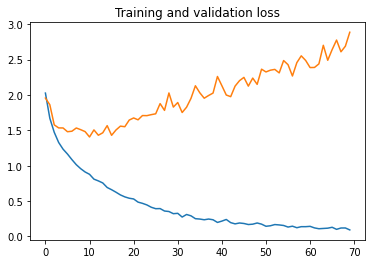

In [ ]:
import matplotlib.pyplot as plt
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

## Model Testing

In [ ]:
import numpy as np
import tensorflow as tf
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

new_model = tf.keras.models.load_model('./saved_model/my_model.h5')
labels = ['blackhead', 'eksim', 'flek hitam', 'herpes', 'jerawat', 'milia', 'panu', 'rosacea', 'tinea fasialis']
input_size = (160,160)
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr
def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)
im = Image.open('/content/07AcnePittedScars.jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = new_model.predict(X)



In [ ]:
print( labels[np.argmax(y)], np.max(y) )

jerawat 0.99981624
